In [1]:
from utils import import_train_data
df, test_df = import_train_data()
df.sample(10)

,image_path,category,target,r
1715,data/알파벳인식/H/H/4d_al_H_04.jpg,alphabet,H,False
486,data/숫자인식/04/r_n04/4d_r_n04_37.jpg,number,4,True
513,data/숫자인식/05/n05/4d_n05_13.jpg,number,5,False
2738,data/알파벳인식/R/R/4d_al_R_17.jpg,alphabet,R,False
119,data/숫자인식/01/n01/4d_n01_20.jpg,number,1,False
1949,data/알파벳인식/J/J/4d_al_J_29.jpg,alphabet,J,False
386,data/숫자인식/03/r_n03/4d_r_n03_37.jpg,number,3,True
302,data/숫자인식/03/n03/4d_n03_02.jpg,number,3,False
136,data/숫자인식/01/n01/4d_n01_37.jpg,number,1,False
1809,data/알파벳인식/H/r_H/4d_al_r_H_49.jpg,alphabet,H,True


In [2]:
test_df.sample(10)

,image_path,category,target,r
1914,data/자유패턴/40/40_g/40_g18.jpg,free_pattern,Free,False
381,data/숫자인식/숫자 추가/test_7/te_r_7_07.jpg,number,7,True
1696,data/알파벳인식/알파벳 추가/test_X/te_X_22.jpg,alphabet,X,False
549,data/알파벳인식/알파벳 추가/test_A/te_r_A_25.jpg,alphabet,A,True
1323,data/알파벳인식/알파벳 추가/test_Q/te_Q_24.jpg,alphabet,Q,False
1290,data/알파벳인식/알파벳 추가/test_P/te_r_P_16.jpg,alphabet,P,True
1421,data/알파벳인식/알파벳 추가/test_S/te_r_S_22.jpg,alphabet,S,True
1599,data/알파벳인식/알파벳 추가/test_V/te_V_25.jpg,alphabet,V,False
1427,data/알파벳인식/알파벳 추가/test_S/te_S_03.jpg,alphabet,S,False
1052,data/알파벳인식/알파벳 추가/test_L/te_L_02.jpg,alphabet,L,False


In [4]:
from preprocessing import preprocess_img

X_train_32 = df['image_path'].apply(lambda x: preprocess_img(x, img_size=(32, 32)))

y_train = df['category']
y_train = pd.get_dummies(y_train)
y_train = y_train[['number', 'alphabet', 'free_pattern']]

In [5]:
X_train = df['image_path'].apply(lambda x: preprocess_img(x, img_size=(224, 224)))

In [6]:
from sklearn.model_selection import train_test_split

X_test = test_df['image_path']
y_test = test_df['category']

y_test = pd.get_dummies(y_test)
y_test = y_test[['number', 'alphabet', 'free_pattern']]

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=42, stratify=y_test)
X_val.shape, X_test.shape, y_val.shape, y_test.shape

((1577,), (395,), (1577, 3), (395, 3))

In [7]:
X_val_32 = X_val.apply(lambda x: preprocess_img(x, img_size=(32, 32)))

In [8]:
import numpy as np

X_train_32 = np.stack(X_train_32.values)
X_val_32 = np.stack(X_val_32.values)
X_train_32.shape, X_val_32.shape

((3971, 32, 32, 3), (1577, 32, 32, 3))

In [9]:
y_train.shape, y_val.shape, y_test.shape

((3971, 3), (1577, 3), (395, 3))

In [10]:
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False
base_model.summary()

2023-09-01 06:41:40.436014: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-01 06:41:40.914786: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-01 06:41:40.918042: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 06:41:43.125938: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-01 06:41:44.918941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Do

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [53]:
import tensorflow.keras as keras

inputs = keras.Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = keras.layers.Dense(3, activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
129/129 [==============================] - 15s 114ms/step - loss: 2.5562 - accuracy: 0.4944 - val_loss: 0.7607 - val_accuracy: 0.7163
Epoch 2/10
129/129 [==============================] - 14s 112ms/step - loss: 0.9713 - accuracy: 0.5821 - val_loss: 0.7076 - val_accuracy: 0.7163
Epoch 3/10
129/129 [==============================] - 15s 115ms/step - loss: 0.8731 - accuracy: 0.6344 - val_loss: 0.7770 - val_accuracy: 0.7163
Epoch 4/10
129/129 [==============================] - 15s 115ms/step - loss: 0.8548 - accuracy: 0.6376 - val_loss: 0.7546 - val_accuracy: 0.7163
Epoch 5/10
129/129 [==============================] - 14s 107ms/step - loss: 0.8444 - accuracy: 0.6383 - val_loss: 0.7990 - val_accuracy: 0.7094
Epoch 6/10
129/129 [==============================] - 14s 105ms/step - loss: 0.8444 - accuracy: 0.6422 - val_loss: 0.6935 - val_accuracy: 0.7121
Epoch 7/10
129/129 [==============================] - 13s 105ms/step - loss: 0.8347 - accuracy: 0.6444 - val_loss: 0.7771 - val_ac

In [100]:
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 32)           864       ['input_17[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 48, 48, 32)           0         ['bn_Conv1[0

In [57]:
X_train_96 = df['image_path'].apply(lambda x: preprocess_img(x, img_size=(96, 96)))
X_train_96 = np.stack(X_train_96.values)

In [67]:
model = Sequential([
    base_model.layers[-5].output,
    Flatten(),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_96, y_train, validation_data=(X_test_96, y_test_x), epochs=10, batch_size=32)

Epoch 1/10


2023-08-31 20:21:25.734676: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 456523776 exceeds 10% of free system memory.


129/129 [==============================] - 10s 58ms/step - loss: 0.4562 - accuracy: 0.8234
Epoch 2/10
129/129 [==============================] - 7s 56ms/step - loss: 0.2207 - accuracy: 0.9024
Epoch 3/10
129/129 [==============================] - 8s 59ms/step - loss: 0.1680 - accuracy: 0.9351
Epoch 4/10
129/129 [==============================] - 8s 58ms/step - loss: 0.1532 - accuracy: 0.9339
Epoch 5/10
129/129 [==============================] - 8s 58ms/step - loss: 0.0976 - accuracy: 0.9632
Epoch 6/10
129/129 [==============================] - 7s 57ms/step - loss: 0.0859 - accuracy: 0.9649
Epoch 7/10
129/129 [==============================] - 7s 56ms/step - loss: 0.0731 - accuracy: 0.9736
Epoch 8/10
129/129 [==============================] - 7s 56ms/step - loss: 0.0598 - accuracy: 0.9792
Epoch 9/10
129/129 [==============================] - 7s 57ms/step - loss: 0.0594 - accuracy: 0.9789
Epoch 10/10
129/129 [==============================] - 7s 58ms/step - loss: 0.0469 - accuracy: 0.9843

In [61]:
X_test_96 = test_df['image_path'].apply(lambda x: preprocess_img(x, img_size=(96, 96)))

In [63]:
y_test_x = test_df['category']
y_test_x = pd.get_dummies(y_test_x)
y_test_x = y_test_x[['number', 'alphabet', 'free_pattern']]
y_test_x.shape

(1815, 3)

In [96]:
base_model.layers[-98]

In [104]:
x = base_model.output
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(3, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [106]:
model.fit(preprocess_input(X_train_96), y_train, validation_data=(preprocess_input(X_test_96), y_test_x), epochs=10, batch_size=32)

Epoch 1/10
129/129 [==============================] - 11s 82ms/step - loss: 0.9130 - accuracy: 0.6219 - val_loss: 0.7129 - val_accuracy: 0.7163
Epoch 2/10
129/129 [==============================] - 10s 80ms/step - loss: 0.9161 - accuracy: 0.6223 - val_loss: 0.7153 - val_accuracy: 0.7163
Epoch 3/10
129/129 [==============================] - 10s 81ms/step - loss: 0.9083 - accuracy: 0.6308 - val_loss: 0.7480 - val_accuracy: 0.7163
Epoch 4/10
129/129 [==============================] - 11s 82ms/step - loss: 0.9108 - accuracy: 0.6315 - val_loss: 0.7168 - val_accuracy: 0.7163
Epoch 5/10
129/129 [==============================] - 11s 84ms/step - loss: 0.9131 - accuracy: 0.6342 - val_loss: 0.7269 - val_accuracy: 0.7163
Epoch 6/10
129/129 [==============================] - 10s 81ms/step - loss: 0.9077 - accuracy: 0.6347 - val_loss: 0.7810 - val_accuracy: 0.7163
Epoch 7/10
129/129 [==============================] - 11s 88ms/step - loss: 0.9133 - accuracy: 0.6347 - val_loss: 0.7856 - val_accuracy:

In [132]:
from keras.callbacks import EarlyStopping

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_32, y_train, validation_data=(X_val_32, y_val), epochs=30, batch_size=32, callbacks=[early_stopping])

Epoch 1/30
125/125 [==============================] - 3s 16ms/step - loss: 0.7770 - accuracy: 0.6555 - val_loss: 0.8117 - val_accuracy: 0.6982
Epoch 2/30
125/125 [==============================] - 2s 13ms/step - loss: 0.5959 - accuracy: 0.7180 - val_loss: 2.3350 - val_accuracy: 0.1522
Epoch 3/30
125/125 [==============================] - 2s 13ms/step - loss: 0.5531 - accuracy: 0.7273 - val_loss: 1.1295 - val_accuracy: 0.5447
Epoch 4/30
125/125 [==============================] - 2s 13ms/step - loss: 0.5202 - accuracy: 0.7321 - val_loss: 2.3619 - val_accuracy: 0.2181
Epoch 5/30
125/125 [==============================] - 2s 13ms/step - loss: 0.4894 - accuracy: 0.7391 - val_loss: 2.0736 - val_accuracy: 0.2657
Epoch 6/30
125/125 [==============================] - 2s 15ms/step - loss: 0.4706 - accuracy: 0.7353 - val_loss: 2.4965 - val_accuracy: 0.3234
Epoch 6: early stopping


In [138]:
from keras.optimizers import Adam

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_32, y_train, validation_data=(X_val_32, y_val), epochs=30, batch_size=32, callbacks=[early_stopping])

Epoch 1/30
125/125 [==============================] - 2s 9ms/step - loss: 0.8411 - accuracy: 0.6568 - val_loss: 0.8012 - val_accuracy: 0.6595
Epoch 2/30
125/125 [==============================] - 1s 8ms/step - loss: 0.7154 - accuracy: 0.6832 - val_loss: 0.7323 - val_accuracy: 0.6956
Epoch 3/30
125/125 [==============================] - 1s 8ms/step - loss: 0.6214 - accuracy: 0.7112 - val_loss: 0.7314 - val_accuracy: 0.7134
Epoch 4/30
125/125 [==============================] - 1s 8ms/step - loss: 0.5836 - accuracy: 0.7258 - val_loss: 0.7204 - val_accuracy: 0.7096
Epoch 5/30
125/125 [==============================] - 2s 14ms/step - loss: 0.5463 - accuracy: 0.7426 - val_loss: 0.7838 - val_accuracy: 0.7140
Epoch 6/30
125/125 [==============================] - 1s 8ms/step - loss: 0.5304 - accuracy: 0.7444 - val_loss: 0.8178 - val_accuracy: 0.6931
Epoch 7/30
125/125 [==============================] - 1s 7ms/step - loss: 0.5136 - accuracy: 0.7446 - val_loss: 0.7805 - val_accuracy: 0.7191
Epoch

In [164]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

datagen.fit(X_train_32)

augmented_data = datagen.flow(X_train_32, y_train, batch_size=32)

In [167]:
model.fit(
    augmented_data,
    steps_per_epoch=len(X_train_32) // 32,
    epochs=30,
    validation_data=(X_val_32, y_val)
)

Epoch 1/30
  3/124 [..............................] - ETA: 3s - loss: 0.4585 - accuracy: 0.7812

/tmp/ipykernel_42512/1850413948.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


124/124 [==============================] - 3s 25ms/step - loss: 0.4588 - accuracy: 0.7723 - val_loss: 1.0390 - val_accuracy: 0.6601
Epoch 2/30
124/124 [==============================] - 3s 25ms/step - loss: 0.4546 - accuracy: 0.7682 - val_loss: 1.2007 - val_accuracy: 0.6088
Epoch 3/30
124/124 [==============================] - 3s 24ms/step - loss: 0.4530 - accuracy: 0.7713 - val_loss: 1.0593 - val_accuracy: 0.6569
Epoch 4/30
124/124 [==============================] - 3s 24ms/step - loss: 0.4465 - accuracy: 0.7756 - val_loss: 1.0776 - val_accuracy: 0.6741
Epoch 5/30
124/124 [==============================] - 3s 23ms/step - loss: 0.4460 - accuracy: 0.7733 - val_loss: 0.9943 - val_accuracy: 0.6937
Epoch 6/30
124/124 [==============================] - 3s 23ms/step - loss: 0.4460 - accuracy: 0.7791 - val_loss: 1.4903 - val_accuracy: 0.5352
Epoch 7/30
124/124 [==============================] - 3s 23ms/step - loss: 0.4467 - accuracy: 0.7753 - val_loss: 1.1107 - val_accuracy: 0.6386
Epoch 8/30

In [81]:
X_train_20 = X_train.apply(lambda x: cv2.resize(x, (20, 20)))
X_train_20 = np.stack(X_train_20.values)

X_val_20 = X_val.apply(lambda x: preprocess_img(x, img_size=(20, 20)))
X_val_20 = np.stack(X_val_20.values)

X_train_20.shape, X_val_20.shape

((3971, 20, 20, 3), (1577, 20, 20, 3))

In [87]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(20, 20, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(5e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_20, y_train, validation_data=(X_val_20, y_val), epochs=30, batch_size=32)

Epoch 1/30
125/125 [==============================] - 2s 6ms/step - loss: 0.9239 - accuracy: 0.5860 - val_loss: 0.8257 - val_accuracy: 0.6595
Epoch 2/30
125/125 [==============================] - 1s 5ms/step - loss: 0.8298 - accuracy: 0.6598 - val_loss: 0.8137 - val_accuracy: 0.6595
Epoch 3/30
125/125 [==============================] - 1s 5ms/step - loss: 0.8098 - accuracy: 0.6580 - val_loss: 0.8072 - val_accuracy: 0.6595
Epoch 4/30
125/125 [==============================] - 1s 5ms/step - loss: 0.7840 - accuracy: 0.6590 - val_loss: 0.7921 - val_accuracy: 0.6595
Epoch 5/30
125/125 [==============================] - 1s 5ms/step - loss: 0.7546 - accuracy: 0.6651 - val_loss: 0.7725 - val_accuracy: 0.6620
Epoch 6/30
125/125 [==============================] - 1s 5ms/step - loss: 0.7208 - accuracy: 0.6789 - val_loss: 0.7496 - val_accuracy: 0.6785
Epoch 7/30
125/125 [==============================] - 1s 5ms/step - loss: 0.6944 - accuracy: 0.6900 - val_loss: 0.7298 - val_accuracy: 0.6906
Epoch 

In [88]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

datagen.fit(X_train_20)

augmented_data = datagen.flow(X_train_20, y_train, batch_size=32)

In [90]:
model.fit(
    augmented_data,
    steps_per_epoch=len(X_train_20) // 32,
    epochs=20,
    validation_data=(X_val_20, y_val)
)

Epoch 1/20


124/124 [==============================] - 2s 14ms/step - loss: 0.5415 - accuracy: 0.7438 - val_loss: 0.7657 - val_accuracy: 0.6335
Epoch 2/20
124/124 [==============================] - 2s 13ms/step - loss: 0.5450 - accuracy: 0.7423 - val_loss: 0.7634 - val_accuracy: 0.6836
Epoch 3/20
124/124 [==============================] - 2s 14ms/step - loss: 0.5414 - accuracy: 0.7378 - val_loss: 0.7680 - val_accuracy: 0.6614
Epoch 4/20
124/124 [==============================] - 2s 14ms/step - loss: 0.5487 - accuracy: 0.7411 - val_loss: 0.7586 - val_accuracy: 0.6848
Epoch 5/20
124/124 [==============================] - 2s 14ms/step - loss: 0.5436 - accuracy: 0.7446 - val_loss: 0.8464 - val_accuracy: 0.6525
Epoch 6/20
124/124 [==============================] - 2s 14ms/step - loss: 0.5424 - accuracy: 0.7395 - val_loss: 0.7701 - val_accuracy: 0.6690
Epoch 7/20
124/124 [==============================] - 2s 14ms/step - loss: 0.5342 - accuracy: 0.7438 - val_loss: 0.7550 - val_accuracy: 0.6607
Epoch 8/20

In [85]:
model.compile(optimizer=Adam(5e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_20, y_train, validation_data=(X_val_20, y_val), epochs=15, batch_size=32)

Epoch 1/15
125/125 [==============================] - 2s 6ms/step - loss: 0.4351 - accuracy: 0.7887 - val_loss: 0.7935 - val_accuracy: 0.6969
Epoch 2/15
125/125 [==============================] - 1s 5ms/step - loss: 0.4259 - accuracy: 0.7943 - val_loss: 0.8643 - val_accuracy: 0.6874
Epoch 3/15
125/125 [==============================] - 1s 5ms/step - loss: 0.4295 - accuracy: 0.7958 - val_loss: 0.9107 - val_accuracy: 0.6145
Epoch 4/15
125/125 [==============================] - 1s 5ms/step - loss: 0.4214 - accuracy: 0.8011 - val_loss: 0.8938 - val_accuracy: 0.6430
Epoch 5/15
125/125 [==============================] - 1s 5ms/step - loss: 0.4229 - accuracy: 0.7930 - val_loss: 0.8665 - val_accuracy: 0.6455
Epoch 6/15
125/125 [==============================] - 1s 5ms/step - loss: 0.4192 - accuracy: 0.7995 - val_loss: 0.9149 - val_accuracy: 0.6113
Epoch 7/15
125/125 [==============================] - 1s 5ms/step - loss: 0.4194 - accuracy: 0.8023 - val_loss: 0.8959 - val_accuracy: 0.6284
Epoch 

In [91]:
X_test_20 = X_test.apply(lambda x: preprocess_img(x, img_size=(20, 20)))

In [92]:
X_test_20 = np.stack(X_test_20.values)

In [93]:
best_category_model = model

In [94]:
best_category_model.evaluate(X_test_20, y_test)

13/13 [==============================] - 0s 2ms/step - loss: 0.7285 - accuracy: 0.6759


[0.7285266518592834, 0.6759493947029114]

In [95]:
best_category_model.save("models/best_category_model.keras")

In [190]:
X_train_num = df[df['category']=='number']['image_path'].apply(preprocess_img)

y_train_num = df[df['category']=='number']['target']
y_train_num = pd.get_dummies(y_train_num)
y_train_num = y_train_num[[str(i) for i in range(10)]]

In [63]:
X_test_num = test_df[test_df['category']=='number']['image_path'].apply(preprocess_img)

y_test_num = test_df[test_df['category']=='number']['target']
y_test_num = pd.get_dummies(y_test_num)
y_test_num = y_test_num[[str(i) for i in range(10)]]

In [192]:
X_val_num, X_test_num, y_val_num, y_test_num = train_test_split(X_test_num, y_test_num, test_size=0.2, random_state=42, stratify=y_test_num)
X_val_num.shape, X_test_num.shape, y_val_num.shape, y_test_num.shape

((400,), (100,), (400, 10), (100, 10))

In [193]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(20, 20, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [194]:
X_train_num_20 = X_train_num.apply(lambda x: cv2.resize(x, (20, 20)))
X_train_num_20 = np.stack(X_train_num_20.values)

X_val_num_20 = X_val_num.apply(lambda x: cv2.resize(x, (20, 20)))
X_val_num_20 = np.stack(X_val_num_20.values)

In [196]:
model.fit(X_train_num_20, y_train_num, validation_data=(X_val_num_20, y_val_num), epochs=100, batch_size=32)

Epoch 1/100
32/32 [==============================] - 0s 7ms/step - loss: 2.1383 - accuracy: 0.2188 - val_loss: 2.3208 - val_accuracy: 0.0900
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 2.1235 - accuracy: 0.2238 - val_loss: 2.3315 - val_accuracy: 0.1100
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 2.1067 - accuracy: 0.2108 - val_loss: 2.3347 - val_accuracy: 0.1125
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 2.0995 - accuracy: 0.2008 - val_loss: 2.3497 - val_accuracy: 0.1050
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 2.0805 - accuracy: 0.2128 - val_loss: 2.3586 - val_accuracy: 0.1075
Epoch 6/100
32/32 [==============================] - 0s 7ms/step - loss: 2.0576 - accuracy: 0.2108 - val_loss: 2.3750 - val_accuracy: 0.1225
Epoch 7/100
32/32 [==============================] - 0s 7ms/step - loss: 2.0377 - accuracy: 0.2208 - val_loss: 2.3802 - val_accuracy: 0.0825
Epoch 8/100
3

In [202]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

X_train_num_32 = X_train_num.apply(lambda x: cv2.resize(x, (32, 32)))
X_train_num_32 = np.stack(X_train_num_32.values)

X_val_num_32 = X_val_num.apply(lambda x: cv2.resize(x, (32, 32)))
X_val_num_32 = np.stack(X_val_num_32.values)

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_num_32, y_train_num, validation_data=(X_val_num_32, y_val_num), epochs=50, batch_size=32)

Epoch 1/50
32/32 [==============================] - 1s 15ms/step - loss: 2.3264 - accuracy: 0.0989 - val_loss: 2.3066 - val_accuracy: 0.1050
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 2.3080 - accuracy: 0.0819 - val_loss: 2.3067 - val_accuracy: 0.0850
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 2.3002 - accuracy: 0.1379 - val_loss: 2.3063 - val_accuracy: 0.0925
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 2.2995 - accuracy: 0.1099 - val_loss: 2.3059 - val_accuracy: 0.0950
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 2.2982 - accuracy: 0.1219 - val_loss: 2.3050 - val_accuracy: 0.1100
Epoch 6/50
32/32 [==============================] - 0s 9ms/step - loss: 2.2924 - accuracy: 0.1459 - val_loss: 2.3048 - val_accuracy: 0.1075
Epoch 7/50
32/32 [==============================] - 0s 11ms/step - loss: 2.2951 - accuracy: 0.1179 - val_loss: 2.3048 - val_accuracy: 0.0900
Epoch 8/50
32/32 

In [203]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [204]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

datagen.fit(X_train_num_32)

model.fit(datagen.flow(X_train_num_32, y_train_num, batch_size=32),
        steps_per_epoch=len(X_train_num_32) // 32,
        validation_data=(X_val_num_32, y_val_num),
        epochs=30
)

Epoch 1/30
31/31 [==============================] - 2s 32ms/step - loss: 2.3393 - accuracy: 0.0826 - val_loss: 2.3214 - val_accuracy: 0.1000
Epoch 2/30
31/31 [==============================] - 1s 26ms/step - loss: 2.3230 - accuracy: 0.1063 - val_loss: 2.3067 - val_accuracy: 0.1000
Epoch 3/30
31/31 [==============================] - 1s 26ms/step - loss: 2.3085 - accuracy: 0.1135 - val_loss: 2.3028 - val_accuracy: 0.1150
Epoch 4/30
31/31 [==============================] - 1s 26ms/step - loss: 2.3082 - accuracy: 0.1115 - val_loss: 2.3075 - val_accuracy: 0.1025
Epoch 5/30
31/31 [==============================] - 1s 25ms/step - loss: 2.3059 - accuracy: 0.1115 - val_loss: 2.3025 - val_accuracy: 0.1050
Epoch 6/30
31/31 [==============================] - 1s 28ms/step - loss: 2.3064 - accuracy: 0.1001 - val_loss: 2.3041 - val_accuracy: 0.1100
Epoch 7/30
31/31 [==============================] - 1s 24ms/step - loss: 2.2990 - accuracy: 0.1280 - val_loss: 2.3047 - val_accuracy: 0.0900
Epoch 8/30
31

In [205]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(datagen.flow(X_train_num_32, y_train_num, batch_size=32),
        steps_per_epoch=len(X_train_num_32) // 32,
        validation_data=(X_val_num_32, y_val_num),
        epochs=30
)

Epoch 1/30
31/31 [==============================] - 2s 31ms/step - loss: 2.3185 - accuracy: 0.0702 - val_loss: 2.3016 - val_accuracy: 0.1100
Epoch 2/30
31/31 [==============================] - 1s 24ms/step - loss: 2.3040 - accuracy: 0.1022 - val_loss: 2.3007 - val_accuracy: 0.1050
Epoch 3/30
31/31 [==============================] - 1s 24ms/step - loss: 2.3036 - accuracy: 0.1197 - val_loss: 2.3002 - val_accuracy: 0.1275
Epoch 4/30
31/31 [==============================] - 1s 23ms/step - loss: 2.3047 - accuracy: 0.0960 - val_loss: 2.2997 - val_accuracy: 0.1150
Epoch 5/30
31/31 [==============================] - 1s 24ms/step - loss: 2.3024 - accuracy: 0.1094 - val_loss: 2.2996 - val_accuracy: 0.1000
Epoch 6/30
31/31 [==============================] - 1s 24ms/step - loss: 2.2993 - accuracy: 0.1073 - val_loss: 2.2984 - val_accuracy: 0.1175
Epoch 7/30
31/31 [==============================] - 1s 23ms/step - loss: 2.2933 - accuracy: 0.1249 - val_loss: 2.2983 - val_accuracy: 0.1000
Epoch 8/30
31

In [206]:
model.fit(datagen.flow(X_train_num_32, y_train_num, batch_size=32),
        steps_per_epoch=len(X_train_num_32) // 32,
        validation_data=(X_val_num_32, y_val_num),
        epochs=100
)

Epoch 1/100
31/31 [==============================] - 1s 26ms/step - loss: 2.2153 - accuracy: 0.1569 - val_loss: 2.4403 - val_accuracy: 0.1175
Epoch 2/100
31/31 [==============================] - 1s 27ms/step - loss: 2.2131 - accuracy: 0.1465 - val_loss: 2.4301 - val_accuracy: 0.1025
Epoch 3/100
31/31 [==============================] - 1s 26ms/step - loss: 2.1866 - accuracy: 0.1569 - val_loss: 2.4602 - val_accuracy: 0.1175
Epoch 4/100
31/31 [==============================] - 1s 25ms/step - loss: 2.1890 - accuracy: 0.1682 - val_loss: 2.4710 - val_accuracy: 0.1075
Epoch 5/100
31/31 [==============================] - 1s 25ms/step - loss: 2.1833 - accuracy: 0.1765 - val_loss: 2.4809 - val_accuracy: 0.1000
Epoch 6/100
31/31 [==============================] - 1s 23ms/step - loss: 2.1973 - accuracy: 0.1610 - val_loss: 2.4696 - val_accuracy: 0.1075
Epoch 7/100
31/31 [==============================] - 1s 24ms/step - loss: 2.1806 - accuracy: 0.1785 - val_loss: 2.4759 - val_accuracy: 0.1000
Epoch 

In [210]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False

X_train_num_96 = X_train_num.apply(lambda x: cv2.resize(x, (96, 96)))
X_train_num_96 = np.stack(X_train_num_96.values)

X_val_num_96 = X_val_num.apply(lambda x: cv2.resize(x, (96, 96)))
X_val_num_96 = np.stack(X_val_num_96.values)

model = Sequential([
    base_model,
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(5e-5), loss='categorical_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

datagen.fit(X_train_num_96)

model.fit(datagen.flow(X_train_num_96, y_train_num, batch_size=32), steps_per_epoch=len(X_train_num_96) // 32, validation_data=(X_val_num_96, y_val_num), epochs=30)

Epoch 1/30
31/31 [==============================] - 10s 201ms/step - loss: 2.7978 - accuracy: 0.1084 - val_loss: 2.3701 - val_accuracy: 0.1050
Epoch 2/30
31/31 [==============================] - 5s 151ms/step - loss: 2.2591 - accuracy: 0.1455 - val_loss: 2.2937 - val_accuracy: 0.1525
Epoch 3/30
31/31 [==============================] - 5s 151ms/step - loss: 2.2059 - accuracy: 0.1672 - val_loss: 2.2888 - val_accuracy: 0.1750
Epoch 4/30
31/31 [==============================] - 5s 153ms/step - loss: 2.1215 - accuracy: 0.2147 - val_loss: 2.2841 - val_accuracy: 0.2025
Epoch 5/30
31/31 [==============================] - 5s 149ms/step - loss: 2.0693 - accuracy: 0.2250 - val_loss: 2.3103 - val_accuracy: 0.1850
Epoch 6/30
31/31 [==============================] - 5s 152ms/step - loss: 2.0258 - accuracy: 0.2590 - val_loss: 2.3422 - val_accuracy: 0.2175
Epoch 7/30
31/31 [==============================] - 5s 150ms/step - loss: 1.9334 - accuracy: 0.2941 - val_loss: 2.3768 - val_accuracy: 0.2025
Epoch

In [211]:
model.fit(X_train_num_96, y_train_num, validation_data=(X_val_num_96, y_val_num), epochs=10, batch_size=32)

Epoch 1/10
32/32 [==============================] - 4s 130ms/step - loss: 1.2368 - accuracy: 0.5704 - val_loss: 2.5347 - val_accuracy: 0.3375
Epoch 2/10
32/32 [==============================] - 3s 107ms/step - loss: 1.1142 - accuracy: 0.6254 - val_loss: 2.6682 - val_accuracy: 0.3100
Epoch 3/10
32/32 [==============================] - 3s 105ms/step - loss: 1.0026 - accuracy: 0.6573 - val_loss: 2.7513 - val_accuracy: 0.2800
Epoch 4/10
32/32 [==============================] - 3s 106ms/step - loss: 0.9333 - accuracy: 0.6773 - val_loss: 2.8134 - val_accuracy: 0.2900
Epoch 5/10
32/32 [==============================] - 3s 105ms/step - loss: 0.9301 - accuracy: 0.6633 - val_loss: 2.8835 - val_accuracy: 0.2925
Epoch 6/10
32/32 [==============================] - 3s 105ms/step - loss: 0.8545 - accuracy: 0.7063 - val_loss: 3.0150 - val_accuracy: 0.2800
Epoch 7/10
32/32 [==============================] - 3s 106ms/step - loss: 0.8275 - accuracy: 0.6943 - val_loss: 2.9623 - val_accuracy: 0.3000
Epoch 

In [213]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(datagen.flow(X_train_num_96, y_train_num, batch_size=32), steps_per_epoch=len(X_train_num_96) // 32, validation_data=(X_val_num_96, y_val_num), epochs=100)

Epoch 1/100
31/31 [==============================] - 6s 155ms/step - loss: 2.3429 - accuracy: 0.0980 - val_loss: 2.3047 - val_accuracy: 0.1000
Epoch 2/100
31/31 [==============================] - 4s 142ms/step - loss: 2.3159 - accuracy: 0.0877 - val_loss: 2.3052 - val_accuracy: 0.1000
Epoch 3/100
31/31 [==============================] - 4s 141ms/step - loss: 2.3050 - accuracy: 0.0970 - val_loss: 2.3030 - val_accuracy: 0.0975
Epoch 4/100
31/31 [==============================] - 4s 141ms/step - loss: 2.3029 - accuracy: 0.1104 - val_loss: 2.3030 - val_accuracy: 0.0950
Epoch 5/100
31/31 [==============================] - 5s 145ms/step - loss: 2.3019 - accuracy: 0.0949 - val_loss: 2.3024 - val_accuracy: 0.1000
Epoch 6/100
31/31 [==============================] - 5s 144ms/step - loss: 2.3004 - accuracy: 0.1053 - val_loss: 2.3028 - val_accuracy: 0.0900
Epoch 7/100
31/31 [==============================] - 4s 143ms/step - loss: 2.2973 - accuracy: 0.1146 - val_loss: 2.3028 - val_accuracy: 0.1000

In [214]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False
model = Sequential([
    base_model,
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(5e-5), loss='categorical_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

datagen.fit(X_train_num_96)

model.fit(datagen.flow(X_train_num_96, y_train_num, batch_size=32), steps_per_epoch=len(X_train_num_96) // 32, validation_data=(X_val_num_96, y_val_num), epochs=100)

Epoch 1/100
31/31 [==============================] - 8s 160ms/step - loss: 2.5806 - accuracy: 0.1269 - val_loss: 2.3343 - val_accuracy: 0.1275
Epoch 2/100
31/31 [==============================] - 4s 114ms/step - loss: 2.3024 - accuracy: 0.1053 - val_loss: 2.3071 - val_accuracy: 0.1450
Epoch 3/100
31/31 [==============================] - 4s 126ms/step - loss: 2.2832 - accuracy: 0.1125 - val_loss: 2.2962 - val_accuracy: 0.1375
Epoch 4/100
31/31 [==============================] - 4s 123ms/step - loss: 2.2630 - accuracy: 0.1455 - val_loss: 2.2808 - val_accuracy: 0.1375
Epoch 5/100
31/31 [==============================] - 4s 128ms/step - loss: 2.2319 - accuracy: 0.1589 - val_loss: 2.2642 - val_accuracy: 0.1675
Epoch 6/100
31/31 [==============================] - 4s 130ms/step - loss: 2.2256 - accuracy: 0.1569 - val_loss: 2.2658 - val_accuracy: 0.1675
Epoch 7/100
31/31 [==============================] - 4s 129ms/step - loss: 2.1949 - accuracy: 0.1641 - val_loss: 2.2566 - val_accuracy: 0.1850

In [215]:
best_number_model = model

In [64]:
X_test_num_96 = X_test_num.apply(lambda x: cv2.resize(x, (96, 96)))
X_test_num_96 = np.stack(X_test_num_96.values)
best_number_model.evaluate(X_test_num_96, y_test_num)

16/16 [==============================] - 2s 53ms/step - loss: 2.1071 - accuracy: 0.3420


[2.1071479320526123, 0.34200000762939453]

In [218]:
best_number_model.save('models/best_number_model.keras')

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [12]:
X_train_alpha = df[df['category']=='alphabet']['image_path'].apply(preprocess_img)

y_train_alpha = df[df['category']=='alphabet']['target']
y_train_alpha = pd.get_dummies(y_train_alpha)
y_train_alpha = y_train_alpha[[chr(i) for i in range(ord('A'), ord('Z')+1)]]

In [13]:
X_test_alpha = test_df[test_df['category']=='alphabet']['image_path'].apply(preprocess_img)

y_test_alpha = test_df[test_df['category']=='alphabet']['target']
y_test_alpha = pd.get_dummies(y_test_alpha)
y_test_alpha = y_test_alpha[[chr(i) for i in range(ord('A'), ord('Z')+1)]]

In [14]:
X_val_alpha, X_test_alpha, y_val_alpha, y_test_alpha = train_test_split(X_test_alpha, y_test_alpha, test_size=0.2, random_state=42, stratify=y_test_alpha)

In [15]:
X_train_alpha_96 = X_train_alpha.apply(lambda x: cv2.resize(x, (96, 96)))
X_train_alpha_96 = np.stack(X_train_alpha_96.values)

X_val_alpha_96 = X_val_alpha.apply(lambda x: cv2.resize(x, (96, 96)))
X_val_alpha_96 = np.stack(X_val_alpha_96.values)

In [24]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False
model = Sequential([
    base_model,
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(26, activation='softmax')
])

model.compile(optimizer=Adam(5e-5), loss='categorical_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

datagen.fit(X_train_alpha_96)

model.fit(datagen.flow(X_train_alpha_96, y_train_alpha, batch_size=32), steps_per_epoch=len(X_train_alpha_96) // 32, validation_data=(X_val_alpha_96, y_val_alpha), epochs=100)

Epoch 1/100
81/81 [==============================] - 13s 132ms/step - loss: 3.3374 - accuracy: 0.0475 - val_loss: 3.2549 - val_accuracy: 0.0452
Epoch 2/100
81/81 [==============================] - 9s 115ms/step - loss: 3.1783 - accuracy: 0.0641 - val_loss: 3.2271 - val_accuracy: 0.0538
Epoch 3/100
81/81 [==============================] - 9s 115ms/step - loss: 3.1030 - accuracy: 0.0804 - val_loss: 3.1899 - val_accuracy: 0.0663
Epoch 4/100
81/81 [==============================] - 9s 115ms/step - loss: 3.0017 - accuracy: 0.1151 - val_loss: 3.1225 - val_accuracy: 0.1000
Epoch 5/100
81/81 [==============================] - 9s 115ms/step - loss: 2.9011 - accuracy: 0.1426 - val_loss: 3.0876 - val_accuracy: 0.1260
Epoch 6/100
81/81 [==============================] - 9s 115ms/step - loss: 2.8204 - accuracy: 0.1634 - val_loss: 3.0432 - val_accuracy: 0.1413
Epoch 7/100
81/81 [==============================] - 9s 114ms/step - loss: 2.7698 - accuracy: 0.1692 - val_loss: 3.0259 - val_accuracy: 0.151

In [26]:
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_alpha_96, y_train_alpha, validation_data=(X_val_alpha_96, y_val_alpha), epochs=10, batch_size=32)

Epoch 1/10
82/82 [==============================] - 39s 343ms/step - loss: 4.7529 - accuracy: 0.0905 - val_loss: 2.9360 - val_accuracy: 0.2375
Epoch 2/10
82/82 [==============================] - 27s 331ms/step - loss: 3.4020 - accuracy: 0.1240 - val_loss: 2.8575 - val_accuracy: 0.2375
Epoch 3/10
82/82 [==============================] - 27s 332ms/step - loss: 3.0569 - accuracy: 0.1416 - val_loss: 2.8295 - val_accuracy: 0.2375
Epoch 4/10
82/82 [==============================] - 27s 330ms/step - loss: 2.8615 - accuracy: 0.1668 - val_loss: 2.8256 - val_accuracy: 0.2404
Epoch 5/10
82/82 [==============================] - 27s 332ms/step - loss: 2.7535 - accuracy: 0.1908 - val_loss: 2.8267 - val_accuracy: 0.2423
Epoch 6/10
82/82 [==============================] - 27s 331ms/step - loss: 2.6594 - accuracy: 0.2191 - val_loss: 2.8269 - val_accuracy: 0.2462
Epoch 7/10
82/82 [==============================] - 27s 332ms/step - loss: 2.5434 - accuracy: 0.2225 - val_loss: 2.8166 - val_accuracy: 0.2356

In [27]:
base_model.trainable = True
model.compile(optimizer=Adam(1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(datagen.flow(X_train_alpha_96, y_train_alpha, batch_size=32), steps_per_epoch=len(X_train_alpha_96) // 32, validation_data=(X_val_alpha_96, y_val_alpha), epochs=50)

Epoch 1/50
81/81 [==============================] - 40s 353ms/step - loss: 2.8305 - accuracy: 0.2137 - val_loss: 2.8879 - val_accuracy: 0.1990
Epoch 2/50
81/81 [==============================] - 27s 336ms/step - loss: 2.8130 - accuracy: 0.2199 - val_loss: 2.8806 - val_accuracy: 0.2000
Epoch 3/50
81/81 [==============================] - 27s 336ms/step - loss: 2.7766 - accuracy: 0.2133 - val_loss: 2.8731 - val_accuracy: 0.2058
Epoch 4/50
81/81 [==============================] - 27s 337ms/step - loss: 2.7221 - accuracy: 0.2160 - val_loss: 2.8741 - val_accuracy: 0.2096
Epoch 5/50
81/81 [==============================] - 27s 336ms/step - loss: 2.7262 - accuracy: 0.2253 - val_loss: 2.8824 - val_accuracy: 0.2106
Epoch 6/50
81/81 [==============================] - 27s 337ms/step - loss: 2.7371 - accuracy: 0.2272 - val_loss: 2.8934 - val_accuracy: 0.2048
Epoch 7/50
81/81 [==============================] - 27s 336ms/step - loss: 2.7076 - accuracy: 0.2175 - val_loss: 2.9019 - val_accuracy: 0.2019

In [28]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(26, activation='softmax')
])

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
X_train_alpha_26 = X_train_alpha.apply(lambda x: cv2.resize(x, (32, 32)))
X_train_alpha_26 = np.stack(X_train_alpha_26.values)

X_val_alpha_26 = X_val_alpha.apply(lambda x: cv2.resize(x, (32, 32)))
X_val_alpha_26 = np.stack(X_val_alpha_26.values)

model.fit(datagen.flow(X_train_alpha_26, y_train_alpha, batch_size=32), steps_per_epoch=len(X_train_alpha_26) // 32, validation_data=(X_val_alpha_26, y_val_alpha), epochs=100)

Epoch 1/100
81/81 [==============================] - 3s 24ms/step - loss: 3.2648 - accuracy: 0.0417 - val_loss: 3.2608 - val_accuracy: 0.0462
Epoch 2/100
81/81 [==============================] - 2s 22ms/step - loss: 3.2604 - accuracy: 0.0483 - val_loss: 3.2593 - val_accuracy: 0.0365
Epoch 3/100
81/81 [==============================] - 2s 22ms/step - loss: 3.2559 - accuracy: 0.0452 - val_loss: 3.2617 - val_accuracy: 0.0385
Epoch 4/100
81/81 [==============================] - 2s 22ms/step - loss: 3.2525 - accuracy: 0.0440 - val_loss: 3.2615 - val_accuracy: 0.0404
Epoch 5/100
81/81 [==============================] - 2s 22ms/step - loss: 3.2415 - accuracy: 0.0576 - val_loss: 3.2643 - val_accuracy: 0.0385
Epoch 6/100
81/81 [==============================] - 2s 21ms/step - loss: 3.2263 - accuracy: 0.0549 - val_loss: 3.2827 - val_accuracy: 0.0433
Epoch 7/100
81/81 [==============================] - 2s 22ms/step - loss: 3.2102 - accuracy: 0.0603 - val_loss: 3.2953 - val_accuracy: 0.0375
Epoch 

KeyboardInterrupt: 

In [31]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(26, activation='softmax')
])

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(datagen.flow(X_train_alpha_96, y_train_alpha, batch_size=32), steps_per_epoch=len(X_train_alpha_96) // 32, validation_data=(X_val_alpha_96, y_val_alpha), epochs=50)

Epoch 1/50
81/81 [==============================] - 13s 128ms/step - loss: 3.2557 - accuracy: 0.0707 - val_loss: 3.1939 - val_accuracy: 0.0875
Epoch 2/50
81/81 [==============================] - 9s 109ms/step - loss: 3.0715 - accuracy: 0.1078 - val_loss: 3.0900 - val_accuracy: 0.1221
Epoch 3/50
81/81 [==============================] - 9s 110ms/step - loss: 2.9520 - accuracy: 0.1260 - val_loss: 3.0734 - val_accuracy: 0.1087
Epoch 4/50
81/81 [==============================] - 9s 110ms/step - loss: 2.8660 - accuracy: 0.1484 - val_loss: 3.0143 - val_accuracy: 0.1269
Epoch 5/50
81/81 [==============================] - 9s 110ms/step - loss: 2.8091 - accuracy: 0.1434 - val_loss: 3.0180 - val_accuracy: 0.1260
Epoch 6/50
81/81 [==============================] - 9s 110ms/step - loss: 2.7753 - accuracy: 0.1526 - val_loss: 2.9642 - val_accuracy: 0.1510
Epoch 7/50
81/81 [==============================] - 9s 109ms/step - loss: 2.7152 - accuracy: 0.1754 - val_loss: 2.9442 - val_accuracy: 0.1587
Epoch

In [34]:
model.compile(optimizer=Adam(5e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(datagen.flow(X_train_alpha_96, y_train_alpha, batch_size=32), steps_per_epoch=len(X_train_alpha_96) // 32, validation_data=(X_val_alpha_96, y_val_alpha), epochs=50)

Epoch 1/50
81/81 [==============================] - 13s 126ms/step - loss: 1.8501 - accuracy: 0.3825 - val_loss: 2.9413 - val_accuracy: 0.2106
Epoch 2/50
81/81 [==============================] - 9s 111ms/step - loss: 1.8009 - accuracy: 0.3906 - val_loss: 2.9066 - val_accuracy: 0.2144
Epoch 3/50
81/81 [==============================] - 9s 112ms/step - loss: 1.8202 - accuracy: 0.3864 - val_loss: 2.9393 - val_accuracy: 0.2106
Epoch 4/50
81/81 [==============================] - 9s 110ms/step - loss: 1.8026 - accuracy: 0.3891 - val_loss: 2.9640 - val_accuracy: 0.2067
Epoch 5/50
81/81 [==============================] - 9s 109ms/step - loss: 1.8118 - accuracy: 0.3914 - val_loss: 2.9533 - val_accuracy: 0.2067
Epoch 6/50
81/81 [==============================] - 9s 110ms/step - loss: 1.8117 - accuracy: 0.3837 - val_loss: 2.9375 - val_accuracy: 0.2106
Epoch 7/50
81/81 [==============================] - 9s 109ms/step - loss: 1.8214 - accuracy: 0.3930 - val_loss: 2.9673 - val_accuracy: 0.2135
Epoch

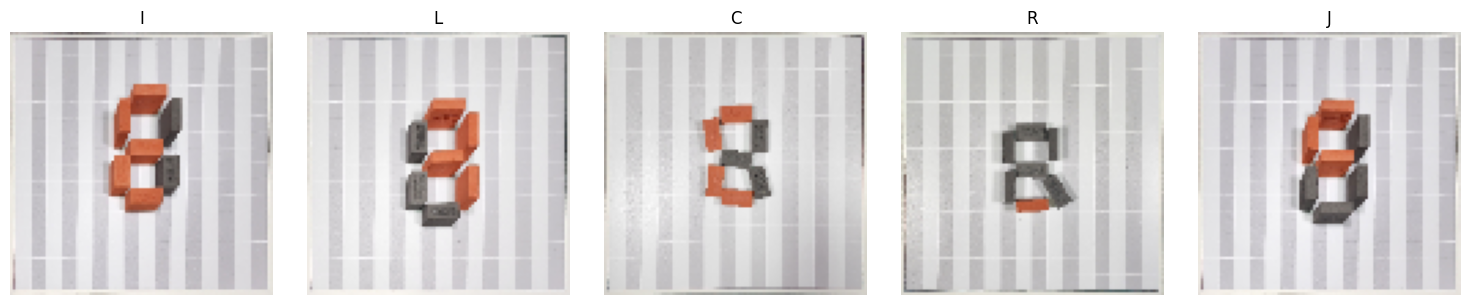

In [41]:
sample_indices = random.sample(range(len(X_train_alpha_96)), 5)
random_sample = X_train_alpha_96[sample_indices]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):

    axes[i].imshow(random_sample[i])
    axes[i].set_title(y_train_alpha.iloc[sample_indices[i]].idxmax())
    axes[i].axis('off')

plt.tight_layout()
plt.show()

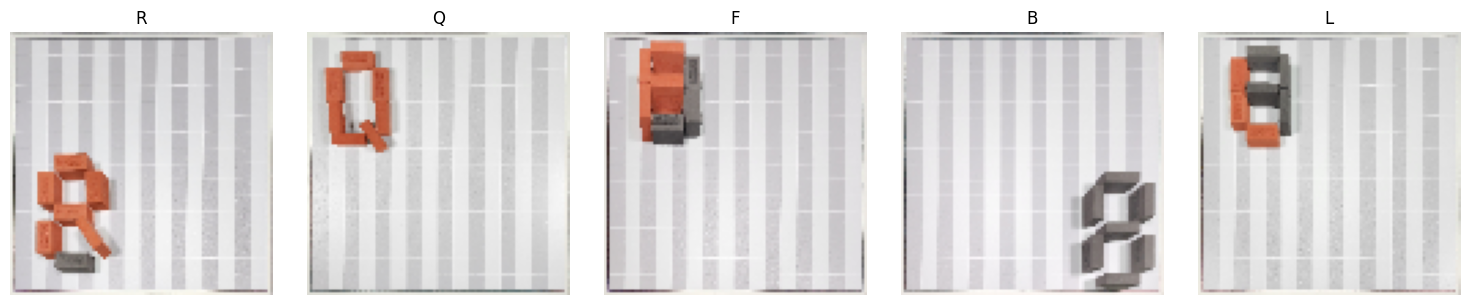

In [42]:
sample_indices = random.sample(range(len(X_val_alpha_96)), 5)
random_sample = X_val_alpha_96[sample_indices]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):

    axes[i].imshow(random_sample[i])
    axes[i].set_title(y_val_alpha.iloc[sample_indices[i]].idxmax())
    axes[i].axis('off')

plt.tight_layout()
plt.show()

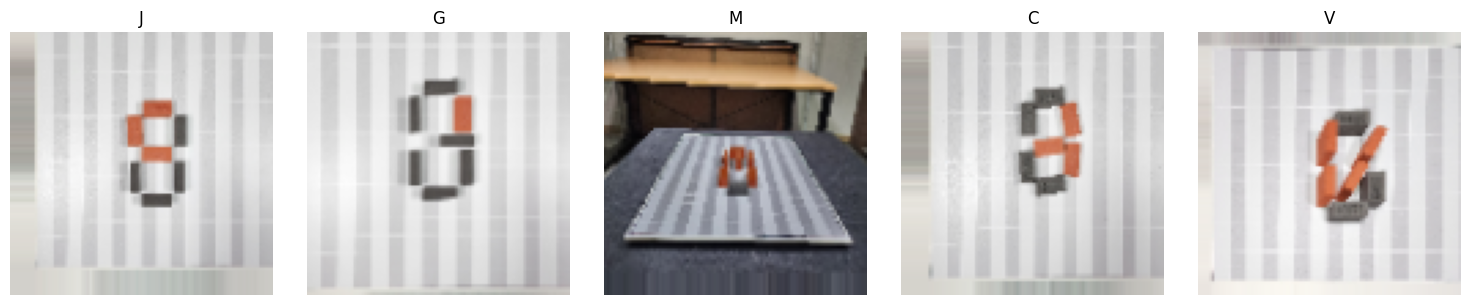

In [48]:
augmented_data = datagen.flow(X_train_alpha_96, y_train_alpha, batch_size=32)
batch = augmented_data.next()
# check some of the augmented images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
classes = [chr(i) for i in range(ord('A'), ord('Z')+1)]
for i in range(5):
        axes[i].imshow(batch[0][i])
        axes[i].set_title(classes[batch[1][i].argmax()])
        axes[i].axis('off')

plt.tight_layout()
plt.show()

In [49]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(26, activation='softmax')
])

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(datagen.flow(X_train_alpha_96, y_train_alpha, batch_size=32), steps_per_epoch=len(X_train_alpha_96) // 32, validation_data=(X_val_alpha_96, y_val_alpha), epochs=50)

Epoch 1/50
81/81 [==============================] - 14s 136ms/step - loss: 3.1627 - accuracy: 0.1132 - val_loss: 3.1120 - val_accuracy: 0.1327
Epoch 2/50
81/81 [==============================] - 10s 118ms/step - loss: 2.6136 - accuracy: 0.2461 - val_loss: 2.9291 - val_accuracy: 0.1635
Epoch 3/50
81/81 [==============================] - 9s 115ms/step - loss: 2.2336 - accuracy: 0.3509 - val_loss: 2.8619 - val_accuracy: 0.1933
Epoch 4/50
81/81 [==============================] - 9s 115ms/step - loss: 1.9840 - accuracy: 0.4065 - val_loss: 2.8063 - val_accuracy: 0.2144
Epoch 5/50
81/81 [==============================] - 10s 121ms/step - loss: 1.8359 - accuracy: 0.4432 - val_loss: 2.8169 - val_accuracy: 0.2144
Epoch 6/50
81/81 [==============================] - 10s 123ms/step - loss: 1.6899 - accuracy: 0.4946 - val_loss: 2.9420 - val_accuracy: 0.2038
Epoch 7/50
81/81 [==============================] - 10s 120ms/step - loss: 1.5749 - accuracy: 0.5162 - val_loss: 2.8541 - val_accuracy: 0.2279
E

In [50]:
model.save('models/best_alphabet_model.keras')

In [51]:
base_model.trainable = True
model.compile(optimizer=Adam(1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_alpha_96, y_train_alpha, validation_data=(X_val_alpha_96, y_val_alpha), epochs=10, batch_size=32)

Epoch 1/10
82/82 [==============================] - 39s 346ms/step - loss: 7.3932 - accuracy: 0.1008 - val_loss: 3.4959 - val_accuracy: 0.2721
Epoch 2/10
82/82 [==============================] - 28s 337ms/step - loss: 6.9027 - accuracy: 0.1095 - val_loss: 3.4298 - val_accuracy: 0.2788
Epoch 3/10
82/82 [==============================] - 28s 336ms/step - loss: 6.3440 - accuracy: 0.1099 - val_loss: 3.4087 - val_accuracy: 0.2702
Epoch 4/10
82/82 [==============================] - 28s 341ms/step - loss: 5.9484 - accuracy: 0.1198 - val_loss: 3.4014 - val_accuracy: 0.2673
Epoch 5/10
82/82 [==============================] - 29s 353ms/step - loss: 5.4944 - accuracy: 0.1317 - val_loss: 3.4214 - val_accuracy: 0.2510
Epoch 6/10
82/82 [==============================] - 28s 346ms/step - loss: 5.2551 - accuracy: 0.1267 - val_loss: 3.4518 - val_accuracy: 0.2490
Epoch 7/10
82/82 [==============================] - 28s 343ms/step - loss: 4.9416 - accuracy: 0.1393 - val_loss: 3.4906 - val_accuracy: 0.2346

In [54]:
from keras.models import load_model
model = load_model('models/best_alphabet_model.keras')

In [55]:
X_test_alpha_96 = X_test_alpha.apply(lambda x: cv2.resize(x, (96, 96)))
X_test_alpha_96 = np.stack(X_test_alpha_96.values)

model.evaluate(X_test_alpha_96, y_test_alpha)

9/9 [==============================] - 2s 51ms/step - loss: 3.5290 - accuracy: 0.2731


[3.529041290283203, 0.2730769217014313]

In [56]:
alpha_predictions = model.predict(X_test_alpha_96)
alpha_predictions = np.argmax(predictions, axis=1)
alpha_true = np.argmax(y_test_alpha.values, axis=1)

9/9 [==============================] - 1s 52ms/step


In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true, predictions)

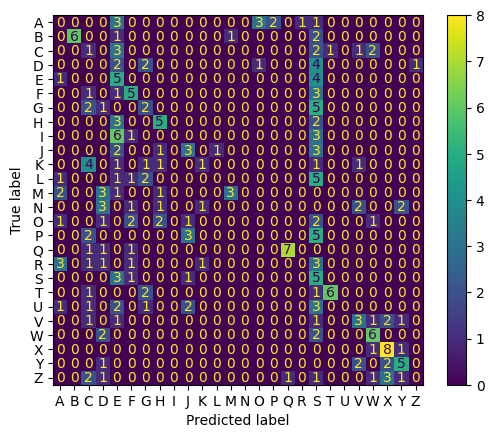

In [59]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()

16/16 [==============================] - 2s 57ms/step


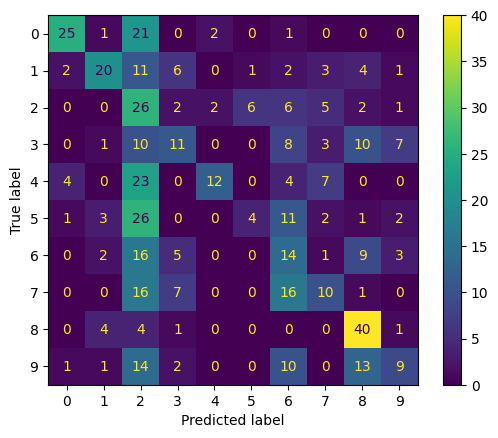

In [65]:
best_number_model = load_model('models/best_number_model.keras')
num_predictions = best_number_model.predict(X_test_num_96)
num_predictions = np.argmax(num_predictions, axis=1)

num_true = np.argmax(y_test_num.values, axis=1)

cm = confusion_matrix(num_true, num_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
disp.plot()
plt.show()

13/13 [==============================] - 0s 2ms/step


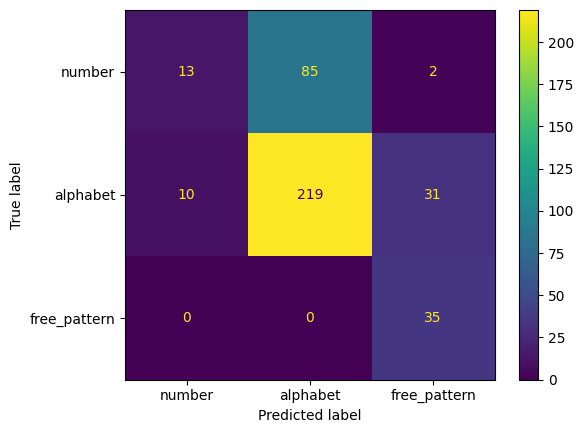

In [96]:
category_predictions = best_category_model.predict(X_test_20)
category_predictions = np.argmax(category_predictions, axis=1)

category_true = np.argmax(y_test.values, axis=1)

cm = confusion_matrix(category_true, category_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['number', 'alphabet', 'free_pattern'])
disp.plot()
plt.show()